# 1. Ładowanie danych

### Rozpakowywanie danych (po pierwszym uruchomieniu)

In [1]:
import os
import zipfile

DATA_PATH = 'data'
ZIP_PATH = 'data.zip'

if not os.path.isdir(DATA_PATH):
    print(f"'{DATA_PATH}' directory not found. Trying to unzip '{ZIP_PATH}'...")
    
    if os.path.isfile(ZIP_PATH):
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall('.')
        print(f"Unzipped '{ZIP_PATH}'")
    else:
        raise FileNotFoundError(f"Neither '{DATA_PATH}' folder nor '{ZIP_PATH}' found.")



### Ładowanie danych do pd.DataFrame

In [2]:
import pandas as pd


def load_data(dataset: str) -> pd.DataFrame:
    if dataset not in [f.split('.')[0] for f in os.listdir(DATA_PATH)]:
        raise FileNotFoundError(f"Dataset {dataset} not available.")

    return pd.read_csv(os.path.join(DATA_PATH, f"{dataset}.csv"))


In [3]:
DATASETS = {
    'creditcard': None,
    'donor': None,
}

for key in DATASETS.keys():
    DATASETS[key] = load_data(key)

# 2. Preprocessing i oczyszczanie danych

### Struktura danych

In [4]:
for key, df in DATASETS.items():
    print(f"\nDATASET: {key}")
    display(df.head(10))
    print(pd.DataFrame({'min': df.min(), 'max': df.max()}))


DATASET: creditcard


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


               min            max
Time      0.000000  172792.000000
V1      -56.407510       2.454930
V2      -72.715728      22.057729
V3      -48.325589       9.382558
V4       -5.683171      16.875344
V5     -113.743307      34.801666
V6      -26.160506      73.301626
V7      -43.557242     120.589494
V8      -73.216718      20.007208
V9      -13.434066      15.594995
V10     -24.588262      23.745136
V11      -4.797473      12.018913
V12     -18.683715       7.848392
V13      -5.791881       7.126883
V14     -19.214325      10.526766
V15      -4.498945       8.877742
V16     -14.129855      17.315112
V17     -25.162799       9.253526
V18      -9.498746       5.041069
V19      -7.213527       5.591971
V20     -54.497720      39.420904
V21     -34.830382      27.202839
V22     -10.933144      10.503090
V23     -44.807735      22.528412
V24      -2.836627       4.584549
V25     -10.295397       7.519589
V26      -2.604551       3.517346
V27     -22.565679      31.612198
V28     -15.43

,at_least_1_teacher_referred_donor=t,fully_funded=t,at_least_1_green_donation=0,great_chat=t,three_or_more_non_teacher_referred_donors=0,one_non_teacher_referred_donor_giving_100_plus=t,donation_from_thoughtful_donor=t,great_messages_proportion,teacher_referred_count,non_teacher_referred_count,class
0,0.00000,1,1.000000,0,1.000000,1.000000,0.000000,0.000000,0.000000,0.003289,0
1,1.00000,1,0.000000,0,0.000000,0.000000,0.000000,0.500000,0.026490,0.029605,0
2,0.00000,1,1.000000,0,1.000000,1.000000,0.000000,0.000000,0.000000,0.003289,0
3,0.00000,0,1.000000,0,1.000000,1.000000,0.000000,0.529271,0.000000,0.006579,0
4,0.00000,1,0.000000,0,1.000000,1.000000,0.000000,0.529271,0.000000,0.003289,0
5,0.00000,1,1.000000,0,1.000000,1.000000,0.000000,0.529271,0.000000,0.006579,0
6,0.23748,0,0.278581,0,0.481114,0.719735,0.013213,0.529271,0.005148,0.014346,0
7,0.00000,0,0.000000,1,1.000000,0.000000,0.000000,1.000000,0.000000,0.003289,0
8,1.00000,1,1.000000,0,0.000000,1.000000,0.000000,0.220000,0.006623,0.055921,0
9,0.23748,0,0.278581,0,0.481114,0.719735,0.013213,0.529271,0.005148,0.014346,0


                                                  min  max
at_least_1_teacher_referred_donor=t               0.0  1.0
fully_funded=t                                    0.0  1.0
at_least_1_green_donation=0                       0.0  1.0
great_chat=t                                      0.0  1.0
three_or_more_non_teacher_referred_donors=0       0.0  1.0
one_non_teacher_referred_donor_giving_100_plus=t  0.0  1.0
donation_from_thoughtful_donor=t                  0.0  1.0
great_messages_proportion                         0.0  1.0
teacher_referred_count                            0.0  1.0
non_teacher_referred_count                        0.0  1.0
class                                             0.0  1.0


### CREDITCARD

Dla tego zbioru danych widzimy, że atrybuty V1-V28 są już znormalizowane. Atrybut `Time` informujący o czasie dokonania transakcji jest zbędny i zostanie usunięty. Jedynym nieznormalizowanym atrybutem jest `Amount`, który zostanie poddany normalizacji. Jako, że atrybuty ciągłe są znormalizowane do rozkładu o średniej 0 i odchyleniu 1, do normalizacji `Amount` zostanie wykorzystany `StandardScaler`.

### DONOR

Zbiór danych zawiera zarówno atrybuty ciągłe jak i dyskretne. Wszystkie cechy ciągłe są już znormalizowane do przedziału `[0, 1]`, więc nie ma potrzeby dodatkowej normalizacji.

### Preprocessing danych


In [5]:
import pandas as pd
from sklearn.utils.validation import check_array
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

DROP_COLUMNS = {
    "creditcard": ['Time'],
    "donor": [],
}
PREPROCESS_DATA = {
    "creditcard": lambda df: preprocess_creditcard(df),
    "donor": lambda df: preprocess_donor(df),
}
SEED = 42
TEST_SIZE = 0.2


def preprocess_creditcard(df: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    df['Amount'] = scaler.fit_transform(df[['Amount']])

    return df


def preprocess_donor(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns={'class': 'Class'})

    return df  # Dane są już znormalizowane (patrz wyżej)


def preprocess_data(df: pd.DataFrame, dataset_name: str, return_unsplit=False) -> list:
    df = df.drop(columns=DROP_COLUMNS[dataset_name])
    df = PREPROCESS_DATA[dataset_name](df)

    X = df.drop('Class', axis=1)
    y = df['Class']

    if not return_unsplit:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            test_size=TEST_SIZE,
            random_state=SEED,
            stratify=y
        )
        return (
            check_array(X_train),
            check_array(X_test),
            y_train.values,
            y_test.values,
        )
    return check_array(X), y.values


In [6]:
from sklearn.utils.validation import check_array

SPLIT_DATASETS = {
    key: preprocess_data(df, key) for key, df in DATASETS.items()
}

for key, (X_train, X_test, y_train, y_test) in SPLIT_DATASETS.items():
    print(f"\n===== STATS FOR {key} ======")

    print("\nTraining set info:")
    print(f"Shape: {X_train.shape}")
    print(f"Fraud percentage: {y_train.mean()*100:.4f}%")

    print("\nTest set info:")
    print(f"Shape: {X_test.shape}")
    print(f"Fraud percentage: {y_test.mean()*100:.4f}%")




===== STATS FOR creditcard ======

Training set info:
Shape: (227845, 29)
Fraud percentage: 0.1729%

Test set info:
Shape: (56962, 29)
Fraud percentage: 0.1720%

===== STATS FOR donor ======

Training set info:
Shape: (495460, 10)
Fraud percentage: 5.9274%

Test set info:
Shape: (123866, 10)
Fraud percentage: 5.9274%


Zgodnie z powyższym widzimy, że dla zbioru `creditcard` średnie zanieczyszczenie (contamination) danych to 0.172% dla zbiorów, co oznacza bardzo dużą dysproporcję. Dodatkowo problemem może być duży rozmiar zbioru (200_000+ próbek).

Zbiór `donor` cechuje się trochę mniejszą dysproporcją (minimalną), przy ponad dwukrotnie większej liczbie próbek.

# 3. Implementacja Detektorów anomalii

Klasa bazowa pozwoli na utworzenie abstrakcji pomocnej przy dalszych testach

In [7]:
from abc import ABC, abstractmethod
import numpy as np


class BaseAnomalyDetector(ABC):
    def __init__(self, contamination: float):
        self._model = None
        self._contamination = contamination

    @abstractmethod
    def fit(self, X: np.array):
        pass

    @abstractmethod
    def score_samples(self, X: np.array) -> np.array:
        pass

    def predict(self, X: np.array) -> np.array:
        scores = self.score_samples(check_array(X))
        threshold = np.percentile(scores, 100 * (1 - self._contamination))
        return np.where(scores >= threshold, 1, 0)


`LocalAnomalyDetector` - wzorowany na `https://www.sciencedirect.com/topics/computer-science/local-outlier-factor`

- Do działania wykorzystywana jest gotowa implementacja `NearestNeighbors` z pakietu `sklearn` pozwalająca na odnalezienie k-najbliższych sąsiadów.
- Działanie opiera się na wsp. `reachability distance`, liczonej jako:
    `reach_dist(A, B) = max{k-distance(B), distance(A, B)}`
    , gdzie:
    - distance(A, B) to zwykła odległość między punktami A i B
    - k-distance(B) to odległość od punktu B do jego k-tego najbliższego sąsiada

    Jeśli punkt A leży blisko B (w obrębie k-sąsiadów B), to reachability distance przyjmuje wartość k-distance(B)

    Jeśli punkt A leży daleko od B (poza obszarem k-sąsiadów B), to reachability distance równa się rzeczywistej odległości między A i B
- `local reachibility distance` jest liczone na podstawie `reachibility distance`:
    `lrd(A, B) = 1 / RD`
    , gdzie:
    - RD - to średnia odległości osiągalności do k-najbliższych sąsiadów.
- Dla każdego punktu obliczany jest `LOF` - stosunek `LRD` jego sąsiadów do jego własnego `LRD`
- Im wyższy wsp. `LOF` tym większa szansa, że próbka jest anomalią. 

In [16]:
from sklearn.neighbors import NearestNeighbors


class LocalAnomalyDetector(BaseAnomalyDetector):
    def __init__(self, contamination, n_neighbors, metric='euclidean'):
        super().__init__(contamination)
        self._n_neighbors = n_neighbors
        self._metric = metric
        self._model = NearestNeighbors(n_neighbors=self._n_neighbors, metric=self._metric)

    def fit(self, X: np.array):
        # zapisany zbiór treningowy do późniejszego wyliczenia lokalnej gęstości
        self._train_save = X
        
        # trening modelu wykrywania k-najblizszych sasiadow
        self._model.fit(X)
    
    def _compute_local_reachability_density(self, X: np.array):
        # odległości punktów do k-najbliższych sąsiadów
        distances, indices = self._model.kneighbors(X)
        
        # k-distance - odległość do k-tego sąsiada
        k_distances = distances[:, -1]
        
        # reachability distance dla każdego punktu i jego sąsiadów
        reach_dist = np.maximum(distances, k_distances.reshape(-1, 1))
        
        # local reachability density (LRD)
        lrd = 1. / (np.mean(reach_dist, axis=1) + 1e-10)  # offset, żeby nie dzielić przez 0
        
        return lrd, indices
    
    def score_samples(self, X: np.array):
        # lrd dla testowych i treningowych
        lrd_test, test_indices = self._compute_local_reachability_density(X)
        lrd_train, _ = self._compute_local_reachability_density(self._train_save)
        
        # LOF dla każdego punktu testowego
        lof_scores = np.zeros(len(X))
        for i in range(len(X)):
            # średnie wartości LRD sąsiadów
            neigh_indices = test_indices[i]
            mean_lrd_neighbors = np.mean(lrd_train[neigh_indices])
            lof_scores[i] = mean_lrd_neighbors / (lrd_test[i] + 1e-10)
        
        return lof_scores

`GlobalAnomalyDetector` - klasyczna implementacja

- Algorytm dla każdej próbki oblicza odległość do k-najbliższych sąsiadów
- Średnia tych odległości jest zwracana jako wynik anomalii
- Im wyższa średnia odległość, tym punkt jest bardziej uznawany jako anomalia
- W odróżnieniu do `LOF`, nie występuje pojęcie lokalności, odległości porównywane są globalnie

In [9]:
class GlobalAnomalyDetector(BaseAnomalyDetector):
    def __init__(self, contamination, n_neighbors, metric='euclidean'):
        super().__init__(contamination)
        self._model = NearestNeighbors(
            n_neighbors=n_neighbors,
            metric=metric
        )
 
    def fit(self, X: np.array):
        self._model.fit(X)

    def score_samples(self, X: np.array):
        distances, _ = self._model.kneighbors(X)
        return distances.mean(axis=1)

`Isolation Forest` i `One Class SVM` - modele baseline

- Wykorzystane, gotowe rozwiązania pochodzące z biblioteki sklearn
- Głównie służą jako punkty odniesienia - jak dobrze sprawdzają się implementacje lokalne i globalne w porównaniu z nimi

In [10]:
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM


class BaseIsolationForest(BaseAnomalyDetector):
    def __init__(self, contamination, n_estimators, max_samples='auto'):
        super().__init__(contamination)
        self._model = IsolationForest(
            contamination=contamination,
            n_estimators=n_estimators,
            max_samples=max_samples,
        )

    def fit(self, X: np.array):
        self._model.fit(X)

    def score_samples(self, X: np.array):
        return -self._model.score_samples(X)


class OneClassSVMDetector(BaseAnomalyDetector):
    def __init__(self, contamination, kernel='rbf', gamma='scale'):
        super().__init__(contamination)
        self._model = OneClassSVM(
            kernel=kernel,
            nu=contamination,
            gamma=gamma
        )
    
    def fit(self, X: np.array):
        self._model.fit(X)

    def score_samples(self, X: np.array):
        return -self._model.score_samples(X)
        

# 4. Testy implementacji dla przykładowych wartości

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    roc_curve
)
from sklearn.utils.validation import check_array
from typing import Dict, Any


def recall_at_fixed_fpr(y_true: np.ndarray, scores: np.ndarray, fpr_threshold: float) -> float:
    fpr, tpr, _ = roc_curve(y_true, scores)
    return tpr[fpr <= fpr_threshold][-1] if any(fpr <= fpr_threshold) else 0


def calculate_metrics(
    y_true: np.ndarray,
    preds: np.ndarray,
    scores: np.ndarray
) -> Dict[str, float]:
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)

    metrics = {
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1': report['1']['f1-score'],
        'AUROC': roc_auc_score(y_true, scores),
        'AUPRC': average_precision_score(y_true, scores),
        'Recall@5%FP': recall_at_fixed_fpr(y_true, scores, 0.05)
    }
    return metrics


def plot_curves(
    y_true: np.ndarray,
    scores: np.ndarray,
    model_name: str,
    auroc: float,
    auprc: float
) -> None:
    precision, recall, _ = precision_recall_curve(y_true, scores)
    fpr, tpr, _ = roc_curve(y_true, scores)

    plt.figure(figsize=(6, 4))

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f"AUROC = {auroc:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f"AUPRC = {auprc:.3f}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()


def evaluate_model(
    model: Any,
    X_test: np.ndarray,
    y_test: np.ndarray,
    model_name: str
) -> Dict[str, float]:
    X_test = check_array(X_test)
    scores = model.score_samples(X_test)
    preds = model.predict(X_test)

    metrics = calculate_metrics(y_test, preds, scores)

    plot_curves(y_test, scores, model_name, metrics['AUROC'], metrics['AUPRC'])

    metrics['Model'] = model_name
    return metrics


Training and evaluating models...:   0%|          | 0/4 [00:00<?, ?it/s]


Training LOF (local)...

Scoring LOF (local)...


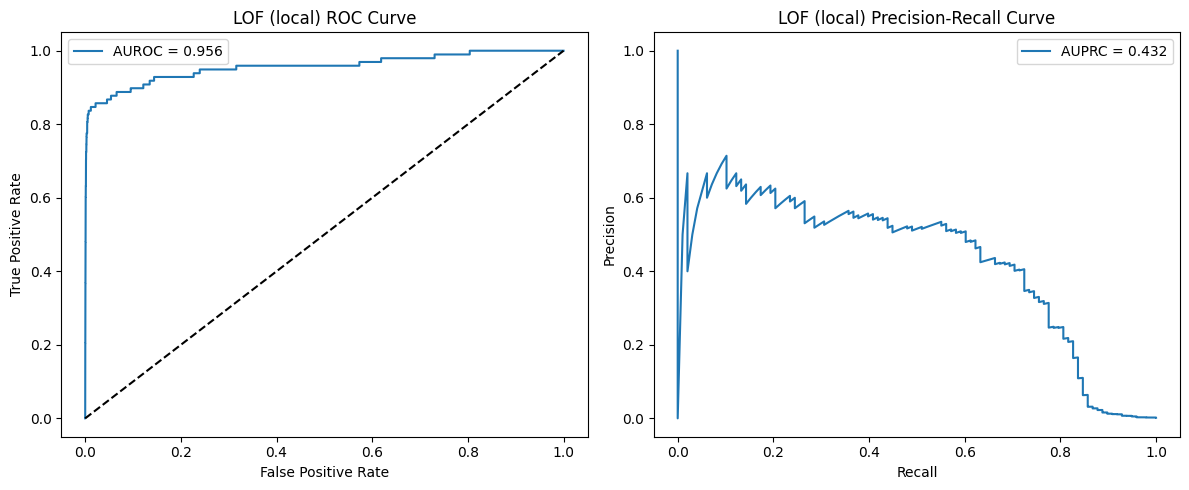

Training and evaluating models...:  25%|██▌       | 1/4 [00:36<01:50, 36.78s/it]


Training Global Distance...

Scoring Global Distance...


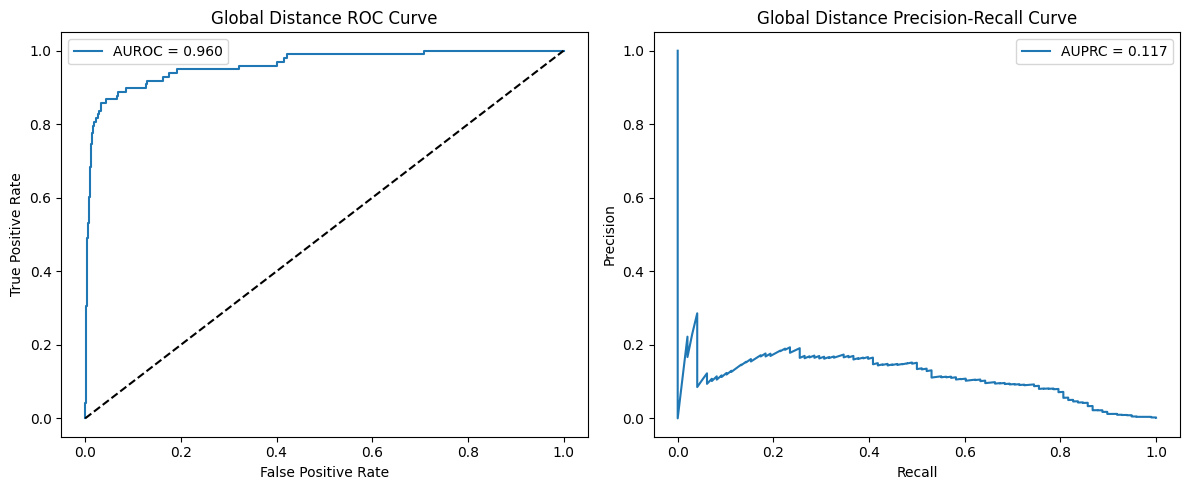

Training and evaluating models...:  50%|█████     | 2/4 [00:42<00:37, 18.57s/it]


Training Isolation Forest...

Scoring Isolation Forest...


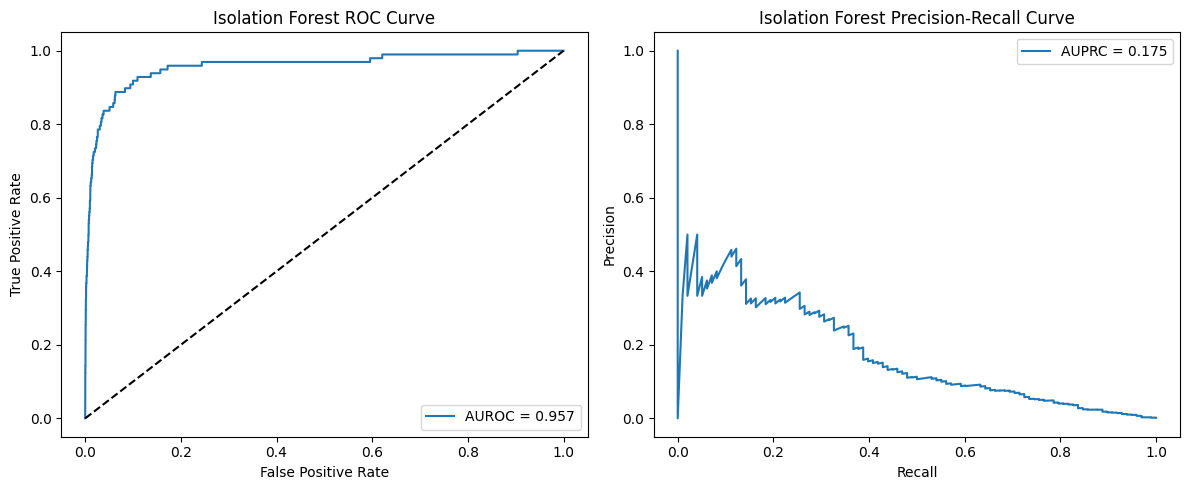

Training and evaluating models...:  75%|███████▌  | 3/4 [00:43<00:10, 10.66s/it]


Training One-Class SVM...

Scoring One-Class SVM...


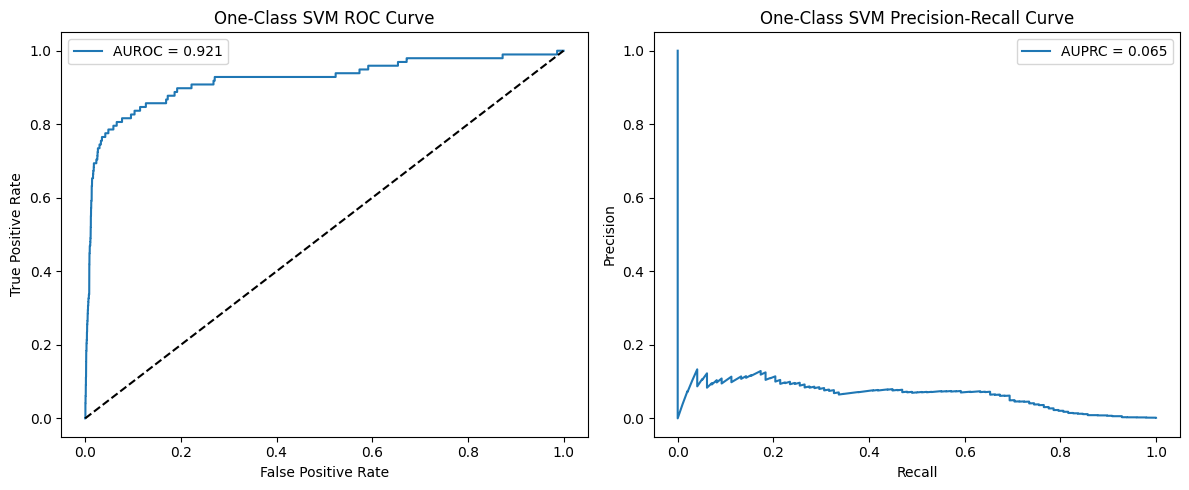

Training and evaluating models...: 100%|██████████| 4/4 [01:29<00:00, 22.28s/it]


Final Comparison:


,Precision,Recall,F1,AUROC,AUPRC,Recall@5%FP,Model
0,0.5253,0.5306,0.5279,0.9562,0.4322,0.8673,LOF (local)
1,0.1717,0.1735,0.1726,0.9603,0.1172,0.8673,Global Distance
2,0.2929,0.2959,0.2944,0.9575,0.1750,0.8367,Isolation Forest
3,0.1111,0.1122,0.1117,0.9205,0.0652,0.7857,One-Class SVM


In [ ]:
from tqdm import tqdm


def compare_models(X_train, X_test, y_test, contamination):
    models = {
        'LOF (local)': LocalAnomalyDetector(
            contamination=contamination,
            n_neighbors=500
        ),

        'Global Distance': GlobalAnomalyDetector(
            contamination=contamination,
            n_neighbors=20
        ),

        'Isolation Forest': BaseIsolationForest(
            contamination=contamination,
            n_estimators=100
        ),

        'One-Class SVM': OneClassSVMDetector(
            contamination=contamination,
        )
    }

    results = []
    for name, model in tqdm(models.items(), total=len(models.keys()), desc="Training and evaluating models..."):
        print(f"\nTraining {name}...")
        model.fit(X_train)
        print(f"\nScoring {name}...")
        results.append(evaluate_model(model, X_test, y_test, name))

    return pd.DataFrame(results)


(X_train, X_test, y_train, y_test) = SPLIT_DATASETS['creditcard']
results_df_credit = compare_models(X_train, X_test, y_test, y_train.mean())

(X_train, X_test, y_train, y_test) = SPLIT_DATASETS['donor']
results_df_donor = compare_models(X_train, X_test, y_test, y_train.mean())

print("\nFinal Comparison:")
print("\n=== CREDITCARD ===")
display(results_df_credit.round(4))
print("\n=== DONOR ===")
display(results_df_donor.round(4))

Uzyskane wyniki nie są najlepsze, ale miały na celu zbadanie czy zaimplementowane algorytmy działają poprawnie. W kolejnym kroku zostanie wykonana faktyczna analiza działania algorytmów za pomocą k-krotnej walidacji krzyżowej.

Ważne jednak są wyniki osiągnięte przez modele stanowiące baseline - IsolationForest oraz OneClassSVM, które później zostaną wykorzystane w ostatecznym porównaniu.

# 5. Analiza przy pomocy k-krotnej walidacji krzyżowej.

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)
import numpy as np
import pandas as pd


def cross_validate_neighbors(X, y, neighbor_values, n_splits=5, clean_train_data=False):
    results = []
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    for n in neighbor_values:
        print(f"\nCross-validating for n_neighbors = {n}...")

        metrics_lof = []
        metrics_global = []

        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            contamination = y_test.mean()
            if clean_train_data:
                X_train = X_train[y_train == 0]

            lof_model = LocalAnomalyDetector(
                contamination=contamination,
                n_neighbors=n
            )
            lof_model.fit(X_train)

            global_model = GlobalAnomalyDetector(
                contamination=contamination,
                n_neighbors=n
            )
            global_model.fit(X_train)

            for model, name, metrics in [
                (lof_model, "LOF", metrics_lof),
                (global_model, "Global", metrics_global)
            ]:
                y_pred = model.predict(X_test)
                y_scores = model.score_samples(X_test)

                precision = precision_score(y_test, y_pred, zero_division=0)
                recall = recall_score(y_test, y_pred, zero_division=0)
                f1 = f1_score(y_test, y_pred, zero_division=0)

                try:
                    auroc = roc_auc_score(y_test, y_scores)
                except ValueError:
                    auroc = np.nan
                try:
                    auprc = average_precision_score(y_test, y_scores)
                except ValueError:
                    auprc = np.nan

                r5fp = recall_at_fixed_fpr(y_test, y_scores, 0.05)

                metrics.append({
                    'Precision': precision,
                    'Recall': recall,
                    'F1': f1,
                    'AUROC': auroc,
                    'AUPRC': auprc,
                    'Recall@5%FP': r5fp
                })

        def summarize(metrics_list):
            df = pd.DataFrame(metrics_list)
            return df.mean().to_dict()

        lof_summary = summarize(metrics_lof)
        global_summary = summarize(metrics_global)

        results.append({
            'n_neighbors': n,
            'Model': 'LOF',
            **lof_summary
        })
        results.append({
            'n_neighbors': n,
            'Model': 'Global',
            **global_summary
        })

    return pd.DataFrame(results)


## 5.1 Zbiór CREDITCARD

In [ ]:
DATASET_NAME = 'creditcard'

In [ ]:
neighbor_vals = [5, 10, 50, 100, 500]
X, y = preprocess_data(load_data(DATASET_NAME), DATASET_NAME, return_unsplit=True)

cv_df_creditcard = cross_validate_neighbors(
    X=X,
    y=y,
    neighbor_values=neighbor_vals,
    n_splits=5
)

display(cv_df_creditcard.round(4))


Cross-validating for n_neighbors = 5...

Cross-validating for n_neighbors = 10...

Cross-validating for n_neighbors = 50...

Cross-validating for n_neighbors = 100...

Cross-validating for n_neighbors = 500...


,n_neighbors,Model,Precision,Recall,F1,AUROC,AUPRC,Recall@5%FP
0,5,LOF,0.0000,0.0000,0.0000,0.4965,0.0017,0.0427
1,5,Global,0.0970,0.0975,0.0973,0.9451,0.0621,0.7987
2,10,LOF,0.0000,0.0000,0.0000,0.5088,0.0019,0.0711
3,10,Global,0.1111,0.1118,0.1114,0.9562,0.0854,0.8618
4,50,LOF,0.0000,0.0000,0.0000,0.5282,0.0025,0.1342
5,50,Global,0.1697,0.1706,0.1702,0.9584,0.1300,0.8719
6,100,LOF,0.0161,0.0163,0.0162,0.5939,0.0035,0.1423
7,100,Global,0.2162,0.2174,0.2168,0.9591,0.1491,0.8719
8,500,LOF,0.5212,0.5244,0.5228,0.9623,0.3906,0.8659
9,500,Global,0.2545,0.2561,0.2553,0.9598,0.2113,0.8638


### Wnioski

- Globalny model radzi sobie znacznie lepiej przy małej liczbie sąsiadów (5, 10, 50, 100) pod względem Precision, Recall, F1, AUROC, AUPRC i Recall@5%FP.

- LOF z małą liczbą sąsiadów (5, 10, 50) nie jest w stanie wykryć anomalii (Precision, Recall i F1 bliskie 0).

- Dopiero przy bardzo dużej liczbie sąsiadów (500) LOF osiąga dobre wyniki (Precision > 0.5, Recall ~0.52, AUROC 0.96), przewyższając globalny model (oraz modele bazowe) w metrykach Precision, Recall i F1.

- Globalny model przy 500 sąsiadach ma dobry AUROC i Recall@5%FP, ale mniejszą precyzję niż LOF.

- Wzrost liczby sąsiadów w LOF znacząco poprawia wyniki, co sugeruje, że ten algorytm wymaga większego kontekstu sąsiedztwa, by dobrze działać.

## 5.2 ZBIÓR DONOR

Zbiór danych jest na tyle duży, że wymagane było jego manualne przycięcie do 200_000 próbek, by dało się wykonać obliczenia

In [14]:
def sample_subset(X, y, n_samples):
    total_samples = X.shape[0]
    if n_samples > total_samples:
        raise ValueError(f"Requested {n_samples} samples, but dataset has only {total_samples}")
    indices = np.random.choice(total_samples, size=n_samples, replace=False)
    return X[indices], y[indices]

In [13]:
DATASET_NAME = 'donor'

In [ ]:
neighbor_vals = [5, 10, 50, 100, 500]
X, y = preprocess_data(load_data(DATASET_NAME), DATASET_NAME, return_unsplit=True)
X, y = sample_subset(X, y, 200_000)

cv_df_donor = cross_validate_neighbors(
    X=X,
    y=y,
    neighbor_values=neighbor_vals,
    n_splits=5
)

display(cv_df_donor.round(4))


Cross-validating for n_neighbors = 5...

Cross-validating for n_neighbors = 10...

Cross-validating for n_neighbors = 50...

Cross-validating for n_neighbors = 100...

Cross-validating for n_neighbors = 500...


## 5.3 Wnioski ogólne i porównanie z modelami bazowymi

# 6. Eksperymenty

## 6.1 Różnica w treningu na danych z anomaliami i bez nich

Celem eksperymentu jest sprawdzenie, jak występowanie anomalii w zbiorze treningowym wpływa na jakość predykcji na zbiorze testowym

In [ ]:
DATASET_NAME = 'creditcard'

In [ ]:
X, y = preprocess_data(load_data(DATASET_NAME), DATASET_NAME, return_unsplit=True)

cv_df_clean_creditcard = cross_validate_neighbors(
    X=X,
    y=y,
    neighbor_values=[100],
    n_splits=5,
    clean_train_data=True
)